# UCI Introduction to Machine Learning
**Day 3: Convolutional Neural Networks**


Notebook adapted by Gage DeZoort from a similar notebook offered in Princeton University's [Introduction to Machine Learning Wintersession course](https://github.com/PrincetonUniversity/intro_machine_learning/tree/main).



<a href="https://colab.research.google.com/github/GageDeZoort/intro_ml_uci/blob/main/day_3/intro_to_ML_day_3_cnns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. The CIFAR-10 Dataset


The goal of this notebook is to demo image classification in the **CIFAR10** dataset using **convolutional neural networks (CNNs)**.

If you'd like to use a GPU, click on `Runtime` (in the Colab toolbar above) then `Change runtime type` and select `T4 GPU`.


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

device = "cuda" # or "cuda" if you want to use the GPU!

The [**CIFAR-10 dataset**](https://www.cs.toronto.edu/~kriz/cifar.html) is a classic benchmark for image classification.  
“CIFAR” stands for **Canadian Institute for Advanced Research**, and “10” refers to its **10 image categories**.

---

**Key properties:**
- **10 classes:** airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck  
- **6,000 images per class** → **60,000 images total**  
- **Image size:** 32×32 pixels, RGB color (so each image has shape **32×32×3**)  
- Standard split: 50,000 for training, 10,000 for testing  

---

Each example in CIFAR-10 is a small, low-resolution color photo representing one of the 10 object categories.  
We’ll train a neural network to recognize which class each image belongs to.

Here’s a quick visual preview

<p align="center">
  <img src="https://raw.githubusercontent.com/GageDeZoort/intro_ml_uci/main/day_3/images/rgb_images.png" width="300">
</p>


**`torchvision`** is a companion library to [PyTorch](https://pytorch.org/) that provides tools, datasets, and models for **computer vision** tasks.

---

**Core modules include:**
- `torchvision.datasets` → standardized datasets for quick loading  
- `torchvision.transforms` → image preprocessing and augmentation tools  
- `torchvision.models` → pretrained CNN and vision transformer architectures  
- `torchvision.utils` → helper functions for visualizing and saving images  

In [2]:
# transform RGB features from [0,1]x3 to [-1,1]x3
transform = transforms.Compose(
  [ # image = (image - mean) / std
      transforms.ToTensor(),
      transforms.Normalize(
          (0.5, 0.5, 0.5), # means
          (0.5, 0.5, 0.5) # stds
      )
   ]
)

# grab the train and test sets
trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
  )
testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

100%|██████████| 170M/170M [00:13<00:00, 12.4MB/s]


With the datasets loaded, we can use the `DataLoader` class provided by torch to conveniently load up random batches of data.

In [3]:
batch_size = 4

# feed the train/test sets into data loaders
trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True,
)
testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False,
)

With our loaders in place, let's plot one batch of data.

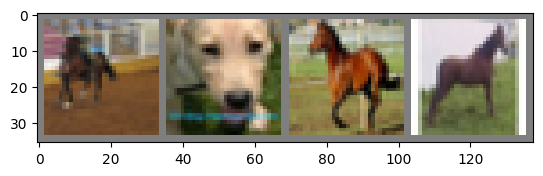

horse dog   horse horse


In [4]:
def imshow(img):
  img = img / 2 + 0.5  # unnormalize
  plt.imshow(np.transpose(img.cpu().numpy(), (1, 2, 0)))
  plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

# truth labels
classes = (
    'plane', 'car', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
)
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

> **EXERCISE 1**: Print the shape of `images` above. Does it make sense?

In [5]:
# EXERCISE 1
images.shape # [batch_size, RGB, ix, iy]



torch.Size([4, 3, 32, 32])

> If you only plot one feature per-pixel instead of 3, it will be interpreted as a greyscale image. Try plotting only one of the RGB features.

In [ ]:
# EXERCISE 1


## 2. Image Classification with a CNN

Our next goal is to define a CNN to do the image classification. The CNN will be a `torch.nn.Module`, which is a generic class designed to hold neural network components. The `forward()` function of the network is the forward pass; everything called there will be used to transform the input data (using learnable weights) and produce a prediction.

**Convolutional Layers**: Convolutional layers use **learnable filters** (also called **kernels**) to detect visual patterns in images. Each filter is a small matrix of **learnable weights** (e.g., 3x3 or 5x5) that slides across the image, computing the **elementwise product** of its weights and the underlying pixel values.

During training, these filter weights are updated via backpropagation so they learn to respond to meaningful features — such as edges, textures, or object parts. Stacking many convolutional layers allows a network to build up increasingly abstract representations of an image, from low-level shapes to high-level concepts.

There is a [wonderful Medium article](https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1) that visualizes the process. Convolutional filters extract high level information from each RGB channel: ![Conv](https://miro.medium.com/v2/resize:fit:2000/format:webp/1*8dx6nxpUh2JqvYWPadTwMQ.gif "conv")

Information extracted from each channel is summed at the output of each convolutional layer: ![ConvSum](https://miro.medium.com/v2/resize:fit:2000/format:webp/1*CYB2dyR3EhFs1xNLK8ewiA.gif "conv-sum")

The filters are **learned** by the algorithm; the intuition is that they become "detectors" for certain image features. For exmaple, here's a nice example of a kernel filter that detects vertical lines (sourced from the Medium article): ![EdgeDetector](https://miro.medium.com/v2/resize:fit:2000/format:webp/1*wju0Urp6KpAT11wktTp5Sg.png "edge-detector")

**Pooling Layers** are designed to downsample images. Contrary to filters, they are *not* learnable, instead representing fixed operations. For example, a pooling layer say "take the maximum value from each 3x3 grid of cells".
![Pooling](https://miro.medium.com/v2/resize:fit:588/format:webp/1*BMngs93_rm2_BpJFH2mS0Q.gif "pooling")

Pooling is used to aggregate information and shape it in a useful way for downstream learning tasks.


Finally, you will see **fully-connected layers**;
these are the simple PyTorch `linear` layers we saw yesteday. After convolutional filters and pooling layers have been applied, the resulting data is flattened and passed through a simple fully connected network to produce classification scores.

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Input image shape: [batch_size, 3, 32, 32]
        #   - 3 channels (RGB)
        #   - 32x32 pixels

        # Conv layer 1:
        #   - 3 input channels → 6 output channels (6 learned filters)
        #   - Each filter is 3x5x5, where the RGB dimension (3) is summed over
        # Output shape after conv1: [batch_size, 6, 28, 28]
        #   → 5x5 filter size narrows the input dimensions by 2
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1)

        # Max pooling layer:
        #   - 2x2 pooling with stride 2 → halves width and height
        # Output shape after pool1: [batch_size, 6, 14, 14]
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Conv layer 2:
        #   - 6 input channels → 16 output channels
        #   - Each filter is 6x5x5, where the feature dimension (6) is summed over
        # Output shape after conv2: [batch_size, 16, 10, 10]
        #   → 5x5 filter narrows the input dimensions by 2
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)

        # In the forward function, we apply the pooling operation again
        # Second pooling → halves 10x10 → 5x5
        # Output shape after pool2: [batch_size, 16, 5, 5]

        # Flattened size = 16 * 5 * 5 = 400 features per image
        # Fully connected layers:
        self.fc1 = nn.Linear(in_features=16 * 5 * 5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)  # 10 classes for CIFAR-10

    def forward(self, x):
        # Input: [batch_size, 3, 32, 32]
        x = self.pool(F.relu(self.conv1(x)))  # → [batch_size, 6, 14, 14]
        x = self.pool(F.relu(self.conv2(x)))  # → [batch_size, 16, 5, 5]
        x = torch.flatten(x, 1)               # → [batch_size, 16*5*5] = [batch_size, 400]
        x = F.relu(self.fc1(x))               # → [batch_size, 120]
        x = F.relu(self.fc2(x))               # → [batch_size, 84]
        x = self.fc3(x)                       # → [batch_size, 10] (class scores)
        return x

net = Net().to(device)
print(net.conv1)

Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))


Stare carefully at the comments in the code above - this is the yoga of CNN dimension bookkeeping. One other word we haven't mentioned yet - the **stride** of the filters is by default `1`, which means they'll slide pixel-by-pixel across the image. However, that's not the only possibility!

Here's a visual of what `stride=2` might look like:

![stride2](https://upload.wikimedia.org/wikipedia/commons/b/b9/Convolution_arithmetic_-_No_padding_strides.gif "stride2")

To put it carefully, in this image we're applying a 3x3 operation (either pooling or convolution) with stride 2.

### Exercise 2
(3 mins)  Knowing this, what is the shape of an image after the pooling stage? Can you make sense of the shapes provided to initialize `self.conv2`? What about the output of `self.conv2`?


In [8]:
image = images[0:1].to(device)
print("Initial image shape:", image.shape)
image_conv1 = net.conv1(image)
print("After conv1:", image_conv1.shape)

# TO-DO: pass image_conv1 to the pooling operator
image_pool = net.pool(image_conv1)
print(image_pool.shape)
#[1,6,14,14]
# TO-DO: pass image_pool to the conv2 operator
image_conv2 = net.conv2(image_pool)
print(image_conv2.shape)
#[]

Initial image shape: torch.Size([1, 3, 32, 32])
After conv1: torch.Size([1, 6, 28, 28])
torch.Size([1, 6, 14, 14])
torch.Size([1, 16, 10, 10])


Since this is a classification problem, we're going to optimize a cross entropy loss. Our strategy will be simple stochastic gradient descent.

In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Here's our training loop - it's fairly standard, so we won't comment too much. Let's press play and train the network!

In [10]:
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.190
[1,  4000] loss: 1.818
[1,  6000] loss: 1.657
[1,  8000] loss: 1.542
[1, 10000] loss: 1.501
[1, 12000] loss: 1.451
[2,  2000] loss: 1.377
[2,  4000] loss: 1.361
[2,  6000] loss: 1.295
[2,  8000] loss: 1.310
[2, 10000] loss: 1.258
[2, 12000] loss: 1.253
[3,  2000] loss: 1.176
[3,  4000] loss: 1.169
[3,  6000] loss: 1.188
[3,  8000] loss: 1.184
[3, 10000] loss: 1.139
[3, 12000] loss: 1.141
[4,  2000] loss: 1.078
[4,  4000] loss: 1.067
[4,  6000] loss: 1.090
[4,  8000] loss: 1.089
[4, 10000] loss: 1.070
[4, 12000] loss: 1.081
[5,  2000] loss: 0.975
[5,  4000] loss: 1.024
[5,  6000] loss: 1.019
[5,  8000] loss: 1.007
[5, 10000] loss: 1.011
[5, 12000] loss: 1.012
Finished Training


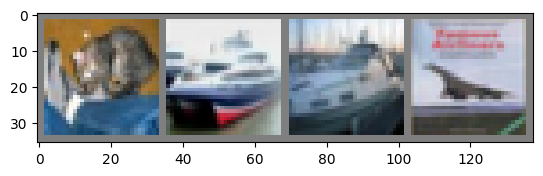

GroundTruth:  cat   ship  ship  plane


In [11]:
dataiter = iter(testloader)
test_data = next(dataiter)
images, labels = test_data[0].to(device), test_data[1].to(device)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))


In [12]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  ship  ship 


In [13]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 62 %


In [14]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 55.7 %
Accuracy for class: car   is 68.2 %
Accuracy for class: bird  is 48.3 %
Accuracy for class: cat   is 47.6 %
Accuracy for class: deer  is 52.2 %
Accuracy for class: dog   is 52.0 %
Accuracy for class: frog  is 77.9 %
Accuracy for class: horse is 75.3 %
Accuracy for class: ship  is 77.8 %
Accuracy for class: truck is 70.2 %


### **EXERCISE 3**

Can you improve these accuracies? Full notebook's worth of code reproduced below for convenience.


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

device = "cuda" # or "cuda" if you want to use the GPU!

classes = (
    'plane', 'car', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
)

# transform RGB features from [0,1]x3 to [-1,1]x3
transform = transforms.Compose(
  [ # image = (image - mean) / std
      transforms.ToTensor(),
      transforms.Normalize(
          (0.5, 0.5, 0.5), # means
          (0.5, 0.5, 0.5) # stds
      )
   ]
)

# grab the train and test sets
trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
  )
testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

batch_size = 4

# feed the train/test sets into data loaders
trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True,
)
testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False,
)

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5, 1) # in_channels, out_channels, kernel_size, stride
        self.pool = nn.MaxPool2d(2, 2) # kernel_size, stride
        self.conv2 = nn.Conv2d(6, 16, 5, 1) # in_channels, out_channels, kernel_size, stride
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # in_channels, out_channels
        self.fc2 = nn.Linear(120, 84) # in_channels, out_channels
        self.fc3 = nn.Linear(84, 10) # in_channels, out_channels

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # learnable convolution, pool result
        x = self.pool(F.relu(self.conv2(x))) # learnable convolution, pool result
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x)) # apply a fully-connected NN
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x # return classification scores

net = Net().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

# Solutions to Exercises


```
#Exercise 1a

# returns [4, 3, 32, 32], corresponding to [batch_size, RGB, ix, iy]
images.shape
```

```
# Exercise 1b

# plot the "R" features only as greyscale
imshow(torchvision.utils.make_grid(images[:,0:1,:,:]))
```

```
Exercise 2

# 2. (3 mins)  Knowing this, what is the shape of an image after the pooling stage? Can you make sense of the shapes provided to initialize `self.conv2`? What about the output of `self.conv2`?

image = images[0:1].to(device)
print("Initial image shape:", image.shape)
image_conv1 = net.conv1(image)
print("After conv1:", image_conv1.shape)
image_pool = net.pool(image_conv1)
print("After pooling:", image_pool.shape)
image_conv2 = net.conv2(image_pool)
print("After conv2:", image_conv2.shape)

```